In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
import keras_tuner as kt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential, Input, Model

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import shutil

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy kaggle.json into it
shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

'C:\\Users\\user/.kaggle/kaggle.json'

In [3]:
# Run this code below in terminal to download the dataset in the current working directory
# c:/Users/user/anaconda3/Scripts/kaggle.exe datasets download -d pranavraikokte/covid19-image-dataset -p ./data


In [4]:
# Extracting dataset inside Python

import zipfile

zip_path = './data/covid19-image-dataset.zip'
extract_path = './data/covid_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted dataset to:", extract_path)

Extracted dataset to: ./data/covid_dataset


In [5]:
# Load Train and Test datasets
train_dir = "./data/covid_dataset/Covid19-dataset/train"
test_dir  = "./data/covid_dataset/Covid19-dataset/test"


# Load training dataset
ds_train_full = keras.utils.image_dataset_from_directory(
    directory=train_dir,
    label_mode="categorical",   # one-hot labels
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42
)

# Save class names
class_names = ds_train_full.class_names
print("Class names:", class_names)

# Split into train & validation (80-20 split)
val_size = int(len(ds_train_full) * 0.2)
ds_train = ds_train_full.skip(val_size)
ds_val   = ds_train_full.take(val_size)

# Load test dataset
ds_test = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    label_mode="categorical",
    batch_size=32,
    image_size=(224,224),
    shuffle=True,
    seed=42
)

# 4. Show dataset size
print("\n Dataset size:")
print("Train batches :", len(ds_train))
print("Validation batches:", len(ds_val))
print("Test batches :", len(ds_test))

Found 251 files belonging to 3 classes.


Class names: ['Covid', 'Normal', 'Viral Pneumonia']
Found 66 files belonging to 3 classes.

 Dataset size:
Train batches : 7
Validation batches: 1
Test batches : 3


## Seeing the same number of samples from each class
### This is very useful for quickly checking data balance and clarity.

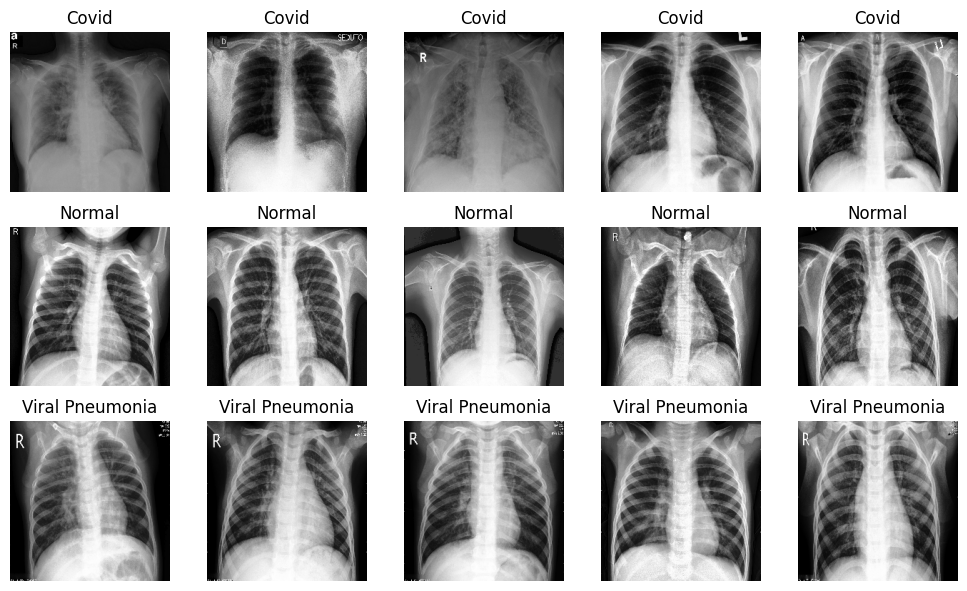

In [6]:
# Plotting the sample images per class
samples_per_class = 5
sample_images = {i: [] for i in range(len(class_names))}

for image_batch, label_batch in ds_train:
    for img, lbl in zip(image_batch, label_batch):
        lbl = np.argmax(lbl.numpy())  # one-hot → index
        if len(sample_images[lbl]) < samples_per_class:
            sample_images[lbl].append(img.numpy())
    if all(len(sample_images[i]) >= samples_per_class for i in range(len(class_names))):
        break

plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))
for label in range(len(class_names)):
    for i in range(samples_per_class):
        plt.subplot(len(class_names), samples_per_class, label * samples_per_class + i + 1)
        plt.imshow(sample_images[label][i].astype("uint8"))
        plt.title(class_names[label])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Helper Function: Dataset Info

def get_dataset_info(dataset, class_names=None):
    total_samples = 0
    num_classes = len(class_names) if class_names else 0
    class_counts = {i: 0 for i in range(num_classes)}

    for images, labels in dataset:
        batch_size = labels.shape[0]
        total_samples += batch_size
        for label in labels:
            class_index = np.argmax(label.numpy())  # one-hot → index
            class_counts[class_index] += 1

    print(f"Total samples: {total_samples}")
    for label, count in class_counts.items():
        name = class_names[label] if class_names else f"Class {label}"
        print(f"{name}: {count} samples")


# Print Dataset Info
print("\nTraining Dataset:")
get_dataset_info(ds_train, class_names)

print("\nValidation Dataset:")
get_dataset_info(ds_val, class_names)

print("\nTesting Dataset:")
get_dataset_info(ds_test, class_names)



Training Dataset:
Total samples: 219
Covid: 97 samples
Normal: 58 samples
Viral Pneumonia: 64 samples

Validation Dataset:
Total samples: 32
Covid: 15 samples
Normal: 8 samples
Viral Pneumonia: 9 samples

Testing Dataset:
Total samples: 66
Covid: 26 samples
Normal: 20 samples
Viral Pneumonia: 20 samples


Training Dataset:
Total samples: 219
Covid: 94 samples
Normal: 62 samples
Viral Pneumonia: 63 samples


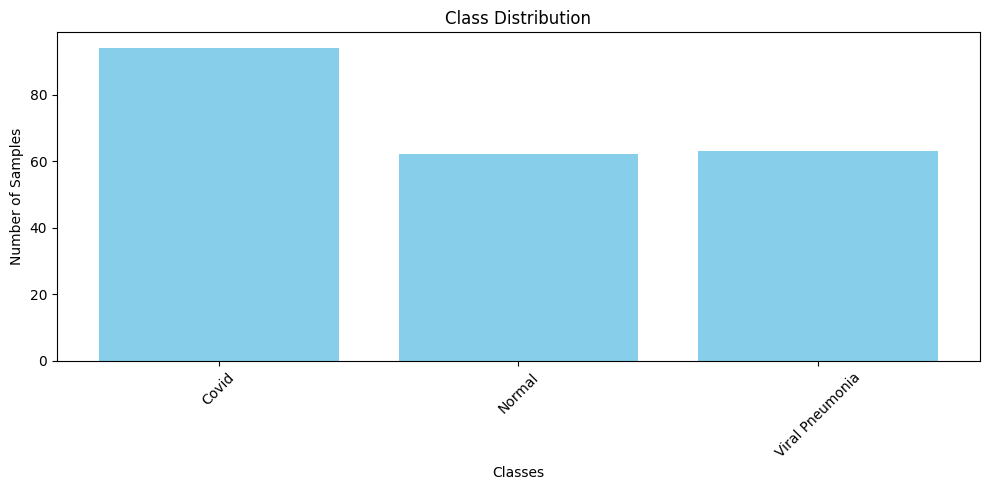


Validation Dataset:
Total samples: 32
Covid: 13 samples
Normal: 7 samples
Viral Pneumonia: 12 samples


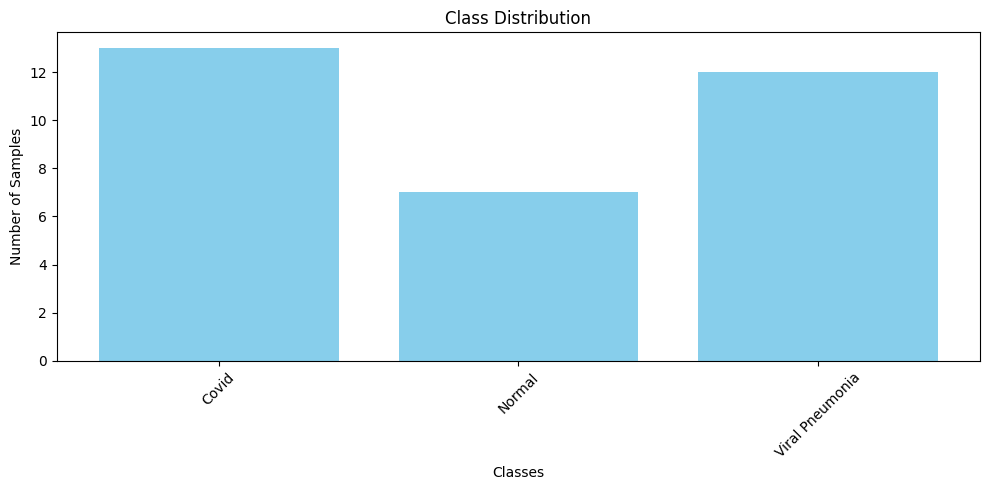


Testing Dataset:
Total samples: 66
Covid: 26 samples
Normal: 20 samples
Viral Pneumonia: 20 samples


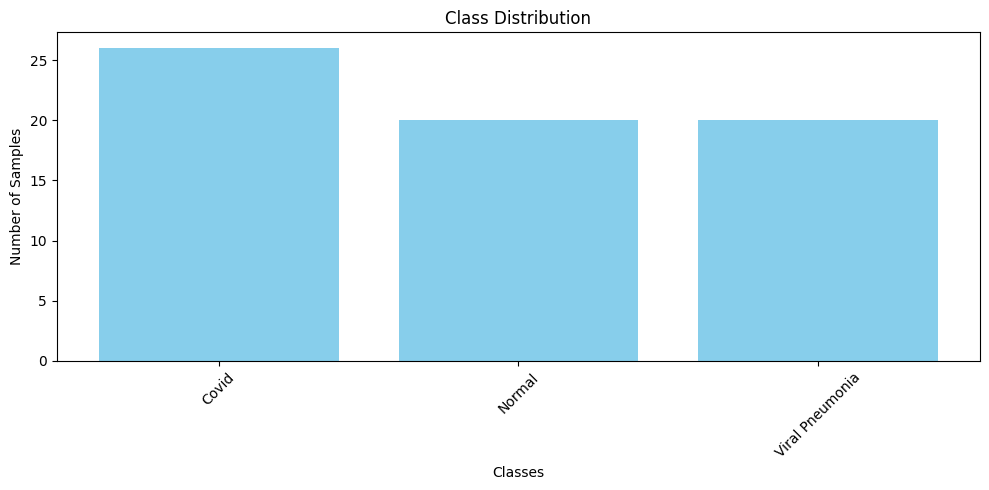

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_dataset_info(dataset, class_names=None):
    """
    Prints and plots class distribution for a given dataset.
    """
    num_classes = len(class_names) if class_names else 10  # Default to 10 classes
    total_samples = 0
    class_counts = {i: 0 for i in range(num_classes)}

    # Count samples per class
    for images, labels in dataset:
        batch_size = labels.shape[0]
        total_samples += batch_size
        for label in labels:
            class_index = np.argmax(label.numpy())  # one-hot → index
            class_counts[class_index] += 1

    # Print dataset info
    print(f"Total samples: {total_samples}")
    for i, count in class_counts.items():
        name = class_names[i] if class_names else f"Class {i}"
        print(f"{name}: {count} samples")

    # Bar chart visualization
    labels = [class_names[i] if class_names else f"Class {i}" for i in range(num_classes)]
    counts = [class_counts[i] for i in range(num_classes)]

    plt.figure(figsize=(10, 5))
    plt.bar(labels, counts, color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print("Training Dataset:")
visualize_dataset_info(ds_train, class_names)

print("\nValidation Dataset:")
visualize_dataset_info(ds_val, class_names)

print("\nTesting Dataset:")
visualize_dataset_info(ds_test, class_names)



In [9]:

def show_sample_images(dataset, class_names=None, num_images=9):
    plt.figure(figsize=(10, 10))
    
    # Get just 1 batch from the dataset
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            image = images[i]
            label = labels[i].numpy()

            # Convert tensor to numpy if needed
            if hasattr(image, "numpy"):
                image = image.numpy()

            # Remove channel dimension if grayscale
            if image.shape[-1] == 1:
                image = np.squeeze(image, axis=-1)

            plt.imshow(image.astype("uint8"))
            plt.axis("off")

            if class_names:
                class_index = np.argmax(label)
                plt.title(class_names[class_index])
            else:
                plt.title(f"Class {np.argmax(label)}")
        break  # only one batch
    
    plt.tight_layout()
    plt.show()


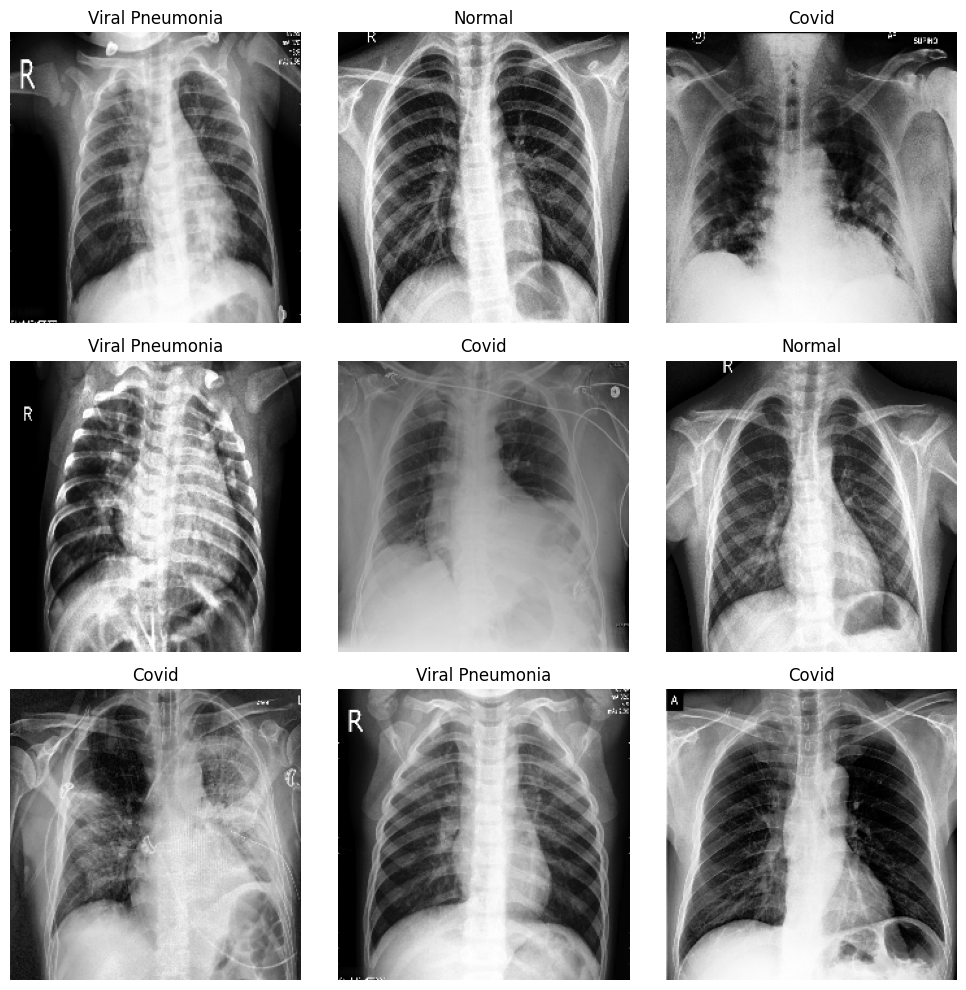

In [10]:
# Show 9 random images from training dataset
show_sample_images(ds_train, class_names=class_names, num_images=9)

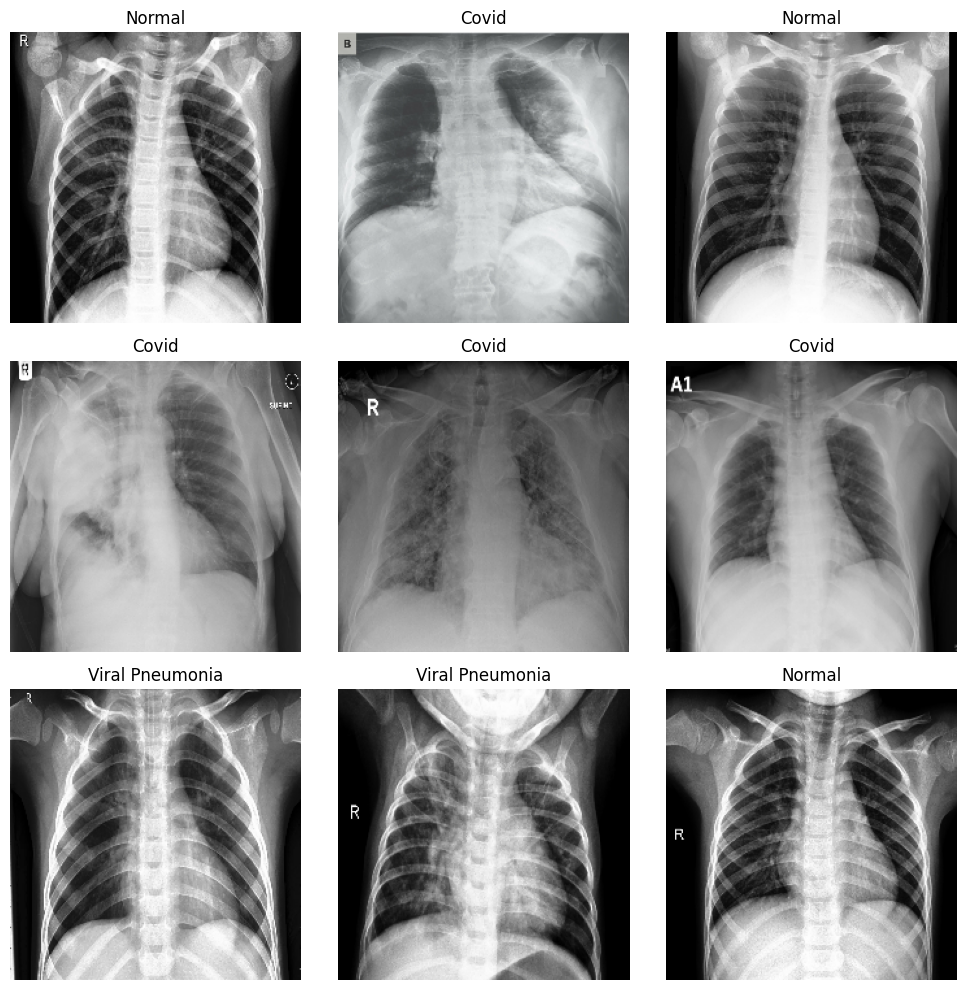

In [11]:
# Show 9 random images from testing dataset
show_sample_images(ds_test, class_names=class_names, num_images=9)


### Preprocessing & Normalization

#### Even though image_dataset_from_directory already resizes and batches for me, I should:
#### Normalize pixel values → convert from [0, 255] to [0, 1].
#### Prefetch & cache datasets → to speed up training.

In [12]:
# Normalize pixel values (scale from 0–255 to 0–1)
def process(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # convert to float32 & normalize
    return image, label

# Apply to all datasets
ds_train = ds_train.map(process)
ds_val   = ds_val.map(process)
ds_test  = ds_test.map(process)


In [13]:
# If I have a big dataset

# AUTOTUNE = tf.data.AUTOTUNE  # Training runs faster and smoother

# def prepare_dataset(ds):
#     ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
#     ds = ds.cache().prefetch(buffer_size=AUTOTUNE)  # performance boost
#     return ds

# ds_train = prepare_dataset(ds_train)
# ds_val   = prepare_dataset(ds_val)
# ds_test  = prepare_dataset(ds_test)

## CNN Model Building
### Basic CNN Model

In [14]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

basic_model = Sequential([
    Input(shape=(224, 224, 3)),  # Explicit input layer

    Conv2D(128, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(64, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # change 3 -> number of classes
])

In [15]:
# Compile the model
basic_model.compile(
    optimizer='adam',          # good default LR for training from scratch / fine-tuning
    loss='categorical_crossentropy',            # your ds uses one-hot labels (label_mode="categorical")
    metrics=['accuracy']                        # basic metric; we'll compute detailed metrics after training
)

In [16]:
# Print summary to verify layers and #params
basic_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,384,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,483,427 (5.66 MB)

 Trainable params: 1,482,979 (5.66 MB)

 Non-trainable params: 448 (1.75 KB)

## Early Stopping

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',       # Stop when validation loss stops improving
    patience=20,               # Wait for 20 epochs before stopping
    restore_best_weights=True # Load best weights after stopping
)

In [18]:
# Train the model
history = basic_model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,                
    callbacks=[early_stop]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5023 - loss: 1.8667 - val_accuracy: 0.2188 - val_loss: 1.0932
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.7671 - loss: 0.6331 - val_accuracy: 0.5312 - val_loss: 0.9187
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.8584 - loss: 0.5381 - val_accuracy: 0.4062 - val_loss: 1.2479
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.9041 - loss: 0.2803 - val_accuracy: 0.3125 - val_loss: 2.0474
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.9361 - loss: 0.2711 - val_accuracy: 0.5312 - val_loss: 3.1848
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.9269 - loss: 0.2581 - val_accuracy: 0.4688 - val_loss: 6.1034
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.9224 - loss: 0.2030 - val_accuracy: 0.3750 - val_loss: 8.3482
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.9543 - loss: 0.1537 - val_accuracy: 0.4375 - val_loss: 8.7650


### Plot Training vs Validation Accuracy

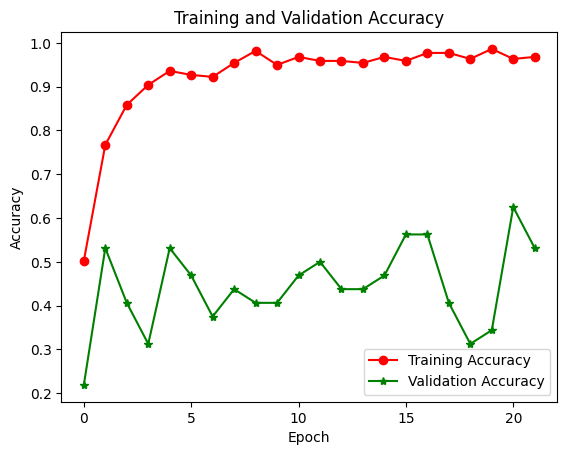

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='*', color='green')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Plot Training vs Validation Loss

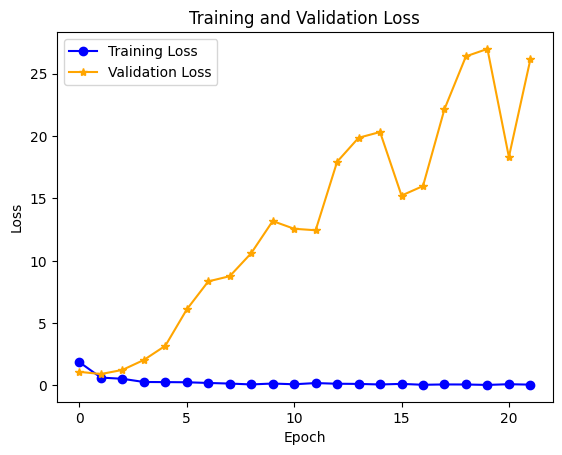

In [21]:
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='*', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
## Now I will evaluate my model on the test dataset and generate detailed metrics.

In [134]:
# Evaluate on Test Dataset

test_loss, test_acc = basic_model.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 463ms/step - accuracy: 0.5455 - loss: 1.0036
Test Loss: 1.0036
Test Accuracy: 0.5455


## Confusion Matrix & Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


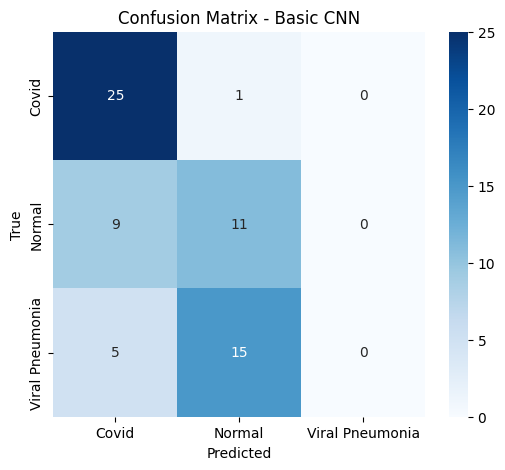

In [23]:
# Gather true and predicted labels
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = basic_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Basic CNN')
plt.show()


In [24]:
# Classification Report
print("Classification Report (Basic CNN):")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report (Basic CNN):
                 precision    recall  f1-score   support

          Covid       0.64      0.96      0.77        26
         Normal       0.41      0.55      0.47        20
Viral Pneumonia       0.00      0.00      0.00        20

       accuracy                           0.55        66
      macro avg       0.35      0.50      0.41        66
   weighted avg       0.38      0.55      0.44        66



## Since this is a multi-class classification problem (Covid, Normal, Viral Pneumonia), we will compute one-vs-rest ROC curves for each class.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


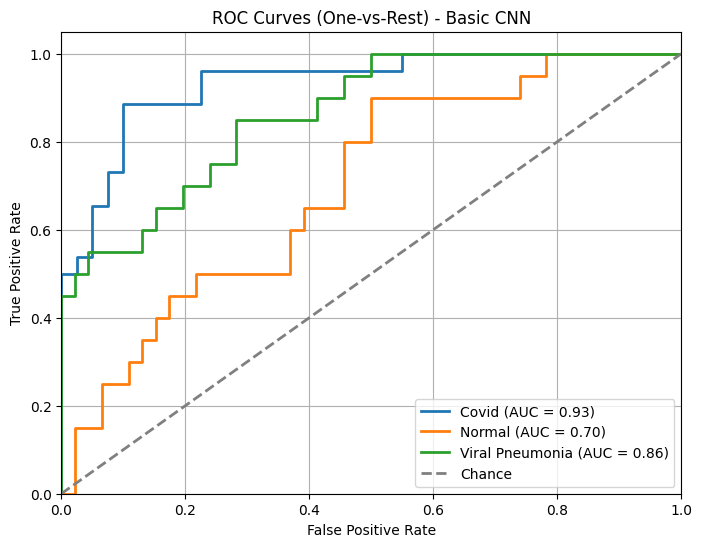

In [25]:
from sklearn.metrics import roc_curve, auc

# For ROC, we need true one-hot and predicted probabilities
y_true_bin = []
y_pred_probs = []

for images, labels in ds_test:
    preds = basic_model.predict(images)
    y_pred_probs.append(preds)
    y_true_bin.append(labels.numpy())

y_true_bin = np.concatenate(y_true_bin, axis=0)        # shape: (num_samples, n_classes)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)    # shape: (num_samples, n_classes)
n_classes = len(class_names)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Draw the diagonal (chance) line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - Basic CNN')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Transfer Learning

In [71]:
# Model 2 using Transfer Learning (VGG16)

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers
import tensorflow as tf

# Load Pretrained Base Model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze convolutional layers

In [34]:
# Build Transfer Learning Model

model_transfer = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Change 3 to your number of classes
])

In [35]:
# Compile Model

model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# Early Stopping

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)


In [37]:
# Train Model
history_transfer = model_transfer.fit(
    ds_train,                  # Use your dataset name
    epochs=50,
    validation_data=ds_val,    # Use your dataset name
    callbacks=[early_stop]
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5160 - loss: 3.9734 - val_accuracy: 0.8125 - val_loss: 0.6580
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8356 - loss: 0.8326 - val_accuracy: 1.0000 - val_loss: 0.0184
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9269 - loss: 0.2936 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9224 - loss: 0.3364 - val_accuracy: 0.9688 - val_loss: 0.0408
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9406 - loss: 0.2262 - val_accuracy: 1.0000 - val_loss: 6.4838e-04
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9726 - loss: 0.0727 - val_accuracy: 1.0000 - val_loss: 7.6016e-04
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9817 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 7.7818e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9726 - loss: 0.0820 - val_accuracy: 1.0000 - val_loss: 1.7

# Visualization

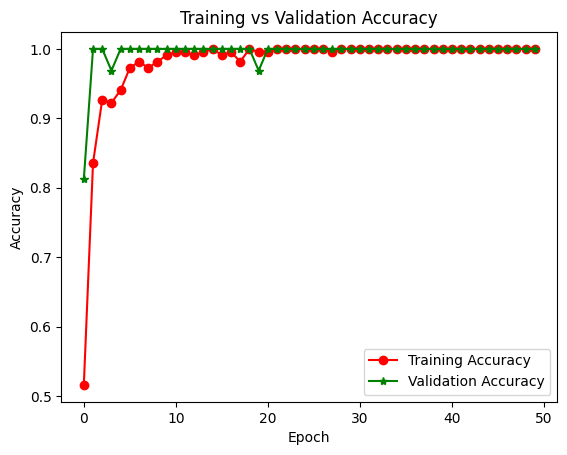

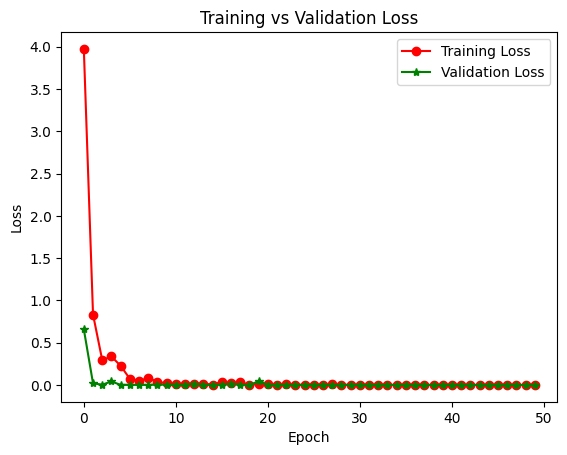

In [38]:
# Training and Valication Accuracy

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy', marker='o', color='red')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy', marker='*', color='green')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Valication Loss

plt.plot(history_transfer.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss', marker='*', color='green')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [39]:
# Evaluation on Test Set
test_loss, test_acc = model_transfer.evaluate(ds_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9697 - loss: 0.0566
Test Loss: 0.0566
Test Accuracy: 0.9697


## Generating Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


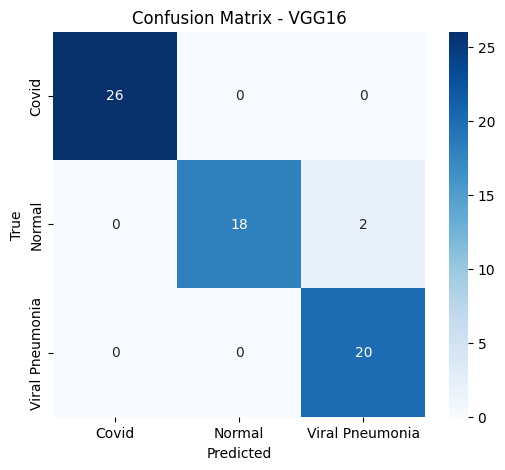

In [40]:
# Start from here, after you have trained your model_transfer
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model_transfer.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Just use 'class_names' here:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG16')
plt.show()

In [41]:
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.90      0.95        20
Viral Pneumonia       0.91      1.00      0.95        20

       accuracy                           0.97        66
      macro avg       0.97      0.97      0.97        66
   weighted avg       0.97      0.97      0.97        66



## # Visualize Predictions on Test Data

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


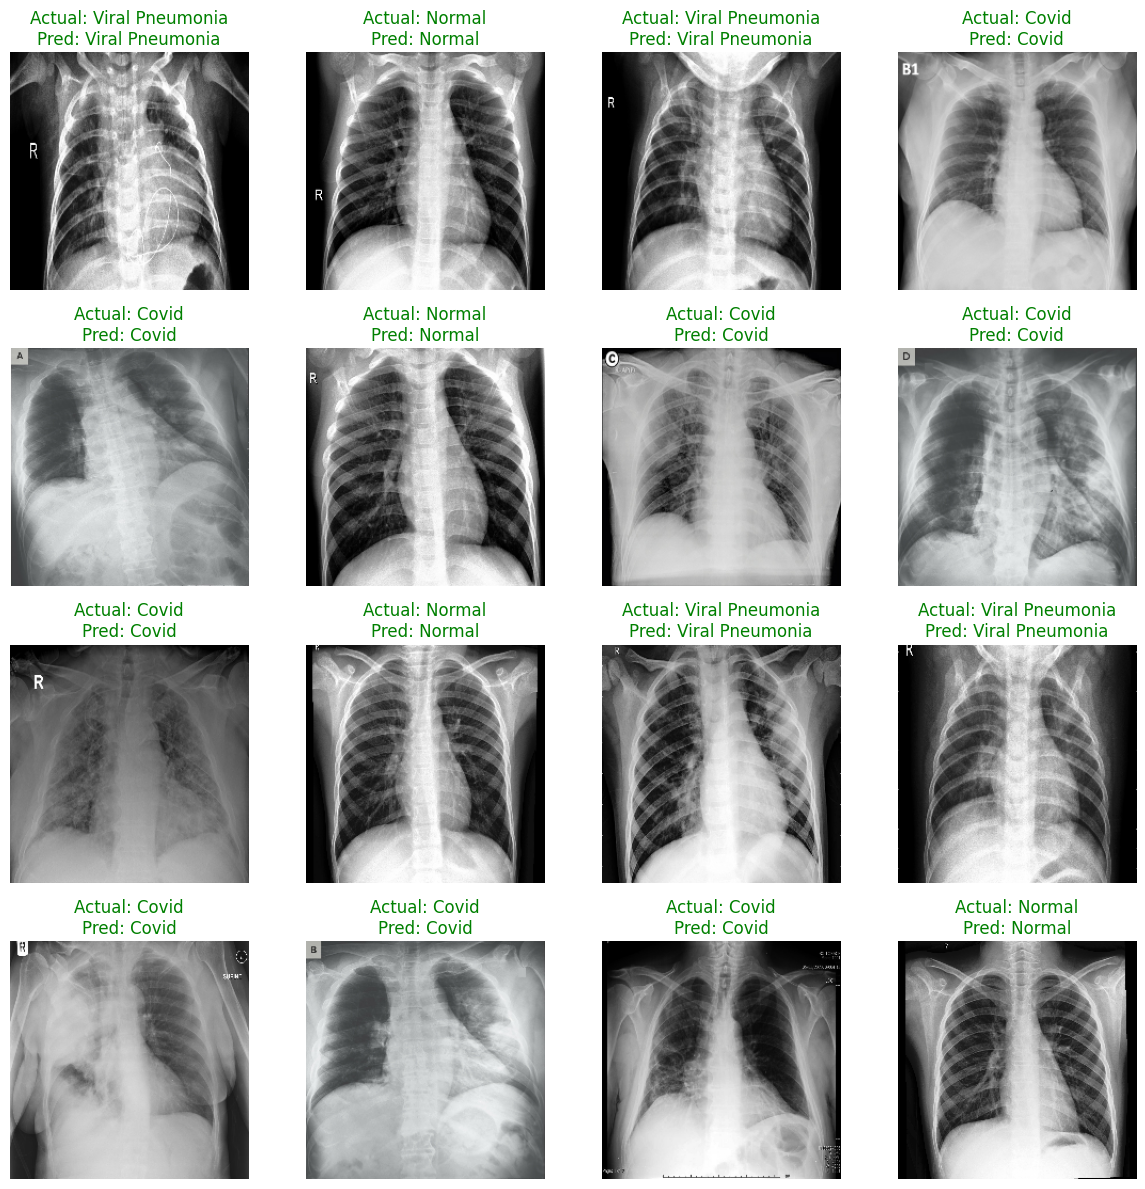

In [42]:
# Manually define class names
best_model = model_transfer 
class_names = ['Covid', 'Normal', 'Viral Pneumonia']

for images, labels in ds_test.take(1):
    preds = best_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)

    num_images = min(len(images), 16)  # show only 16 images max
    plt.figure(figsize=(12, 12))
    
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
        plt.title(
            f"Actual: {class_names[true_classes[i]]}\nPred: {class_names[pred_classes[i]]}",
            color="green" if pred_classes[i] == true_classes[i] else "red"
        )
    
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


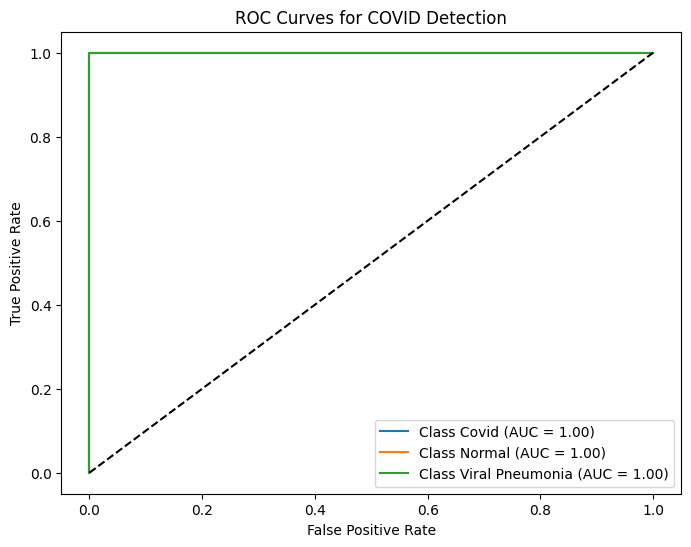

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_true = []
y_pred_proba = []

for images, labels in ds_test:
    preds = best_model.predict(images)
    y_pred_proba.append(preds)
    y_true.append(labels)

y_true = np.concatenate(y_true)
y_pred_proba = np.concatenate(y_pred_proba)

# Binarize labels for ROC (one-hot encoding)
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for COVID Detection")
plt.legend(loc="lower right")
plt.show()


## ResNet50 Model

In [45]:

from tensorflow.keras.applications import ResNet50

# Load Pretrained ResNet50 (without top layer)

resnet_base = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

In [46]:
# Freeze base layers
for layer in resnet_base.layers:
    layer.trainable = False

In [47]:

# Build model sequentially 

model_resnet = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),  # instead of Flatten for better feature reduction
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')   # 3 classes
])

In [48]:
# Compile 
model_resnet.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [49]:
# Callbacks
early_stop_resnet = EarlyStopping(
    monitor = 'val_loss',
    patience = 20,
    restore_best_weights = True,
    verbose = 1
)

In [50]:
# Train
history_resnet = model_resnet.fit(
    ds_train,
    epochs = 100,
    validation_data = ds_val,
    callbacks = [early_stop_resnet],
    verbose = 1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3836 - loss: 1.3937 - val_accuracy: 0.4375 - val_loss: 1.0867
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3333 - loss: 1.5030 - val_accuracy: 0.5312 - val_loss: 1.0887
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4155 - loss: 1.3462 - val_accuracy: 0.5000 - val_loss: 1.0610
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3425 - loss: 1.3779 - val_accuracy: 0.5000 - val_loss: 1.0680
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3744 - loss: 1.4050 - val_accuracy: 0.5625 - val_loss: 1.0765
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.3790 - loss: 1.3151 - val_accuracy: 0.5938 - val_loss: 1.0478
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3927 - loss: 1.3922 - val_accuracy: 0.5000 - val_loss: 1.0080
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4338 - loss: 1.2655 - val_accuracy: 0.5312 - val_loss: 1.0271


In [51]:
# Evaluate model performance
resnet_loss, resnet_acc = model_resnet.evaluate(ds_test, verbose=1)
print(f"ResNet50 Test Loss: {resnet_loss:.4f}")
print(f"ResNet50 Test Accuracy: {resnet_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 743ms/step - accuracy: 0.7424 - loss: 0.6965
ResNet50 Test Loss: 0.6965
ResNet50 Test Accuracy: 0.7424


## Training VS Validation Accuracy and 
## Training VS Validation Loss

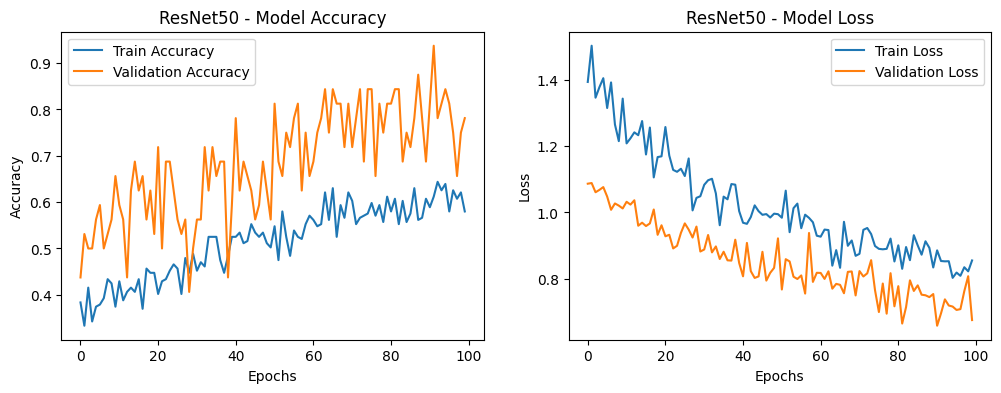

In [54]:
# Accuracy plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50 - Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 - Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Confusion Matrix + Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


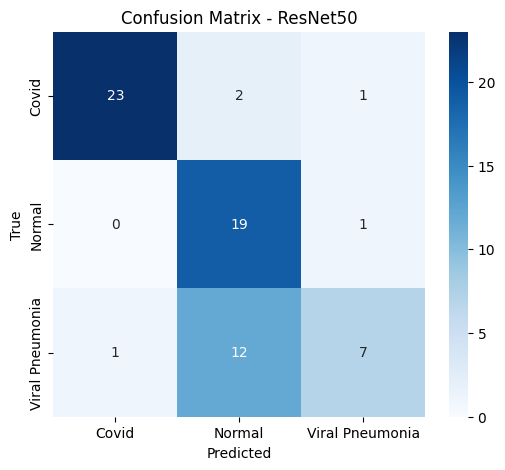

In [56]:
# Use the class_names you already defined:
# class_names = ds_train_full.class_names

# Gather true and predicted labels
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model_resnet.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

In [57]:
# Classification Report
print("Classification Report (ResNet50):")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (ResNet50):
                 precision    recall  f1-score   support

          Covid       0.96      0.88      0.92        26
         Normal       0.58      0.95      0.72        20
Viral Pneumonia       0.78      0.35      0.48        20

       accuracy                           0.74        66
      macro avg       0.77      0.73      0.71        66
   weighted avg       0.79      0.74      0.73        66



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


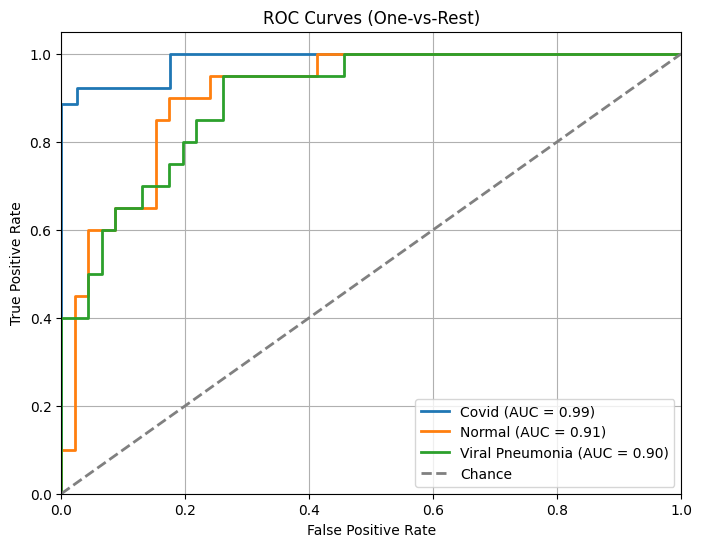

In [58]:
# ROC, AOC Curve 

from sklearn.metrics import roc_curve, auc

# Number of classes (should match your dataset)
n_classes = len(class_names)

# Gather true (one-hot) and predicted probabilities
y_true_bin = []
y_pred_probs = []

for images, labels in ds_test:
    preds = model_resnet.predict(images)  # or vgg19_model.predict(images)
    y_pred_probs.append(preds)
    y_true_bin.append(labels.numpy())

y_true_bin = np.concatenate(y_true_bin, axis=0)        # shape: (num_samples, n_classes)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)    # shape: (num_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Draw the diagonal (chance) line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## VGG19

In [59]:
from tensorflow.keras.applications import VGG19

# Import the base VGG19 model (without top)
base_vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_vgg19.trainable = False  # Freeze base weights

In [60]:
# Build the model
vgg19_model = Sequential([
    Input(shape=(224, 224, 3)),
    base_vgg19,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Change 3 to the number of classes if needed
])

In [61]:
# Compile the Model
vgg19_model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
# Early Stopping Callback
early_stop_vgg19 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [63]:
# Train the VGG19 model (using YOUR variable name)
history_vgg19 = vgg19_model.fit(
    ds_train,
    epochs=100,                    
    validation_data=ds_val,
    callbacks=[early_stop_vgg19],
    verbose=1
)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4429 - loss: 1.0876 - val_accuracy: 0.6250 - val_loss: 0.8707
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5845 - loss: 0.8829 - val_accuracy: 0.7812 - val_loss: 0.6716
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6530 - loss: 0.7706 - val_accuracy: 0.8125 - val_loss: 0.5731
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.7306 - loss: 0.6873 - val_accuracy: 0.8750 - val_loss: 0.5334
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8265 - loss: 0.5341 - val_accuracy: 0.8750 - val_loss: 0.5427
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8265 - loss: 0.4955 - val_accuracy: 0.8750 - val_loss: 0.4156
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8265 - loss: 0.4880 - val_accuracy: 0.8125 - val_loss: 0.4532
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.8904 - loss: 0.3951 - val_accuracy: 0.8125 - val_loss: 0.3508


In [64]:
# Evaluate model performance
vgg19_loss, vgg19_acc = vgg19_model.evaluate(ds_test)
print(f"VGG19 Test Loss: {vgg19_loss:.4f}")
print(f"VGG19 Test Accuracy: {vgg19_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9394 - loss: 0.1573
VGG19 Test Loss: 0.1573
VGG19 Test Accuracy: 0.9394


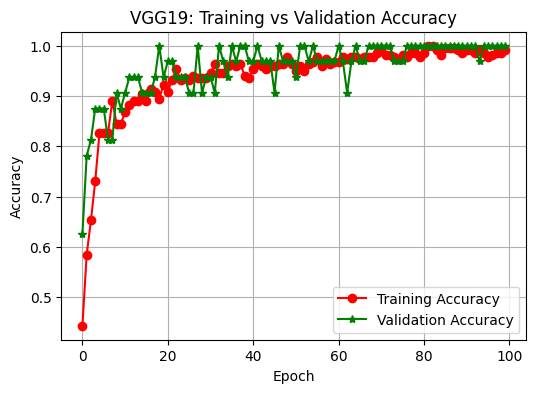

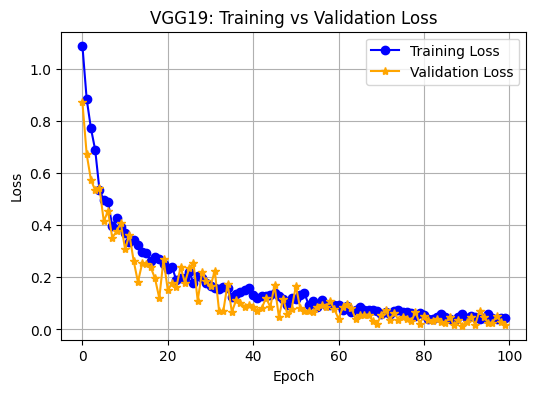

In [65]:
#Training Accuracy vs Validation Accuracy

# Accuracy plot
plt.figure(figsize=(6,4))
plt.plot(history_vgg19.history['accuracy'], label='Training Accuracy', marker='o', color='red')
plt.plot(history_vgg19.history['val_accuracy'], label='Validation Accuracy', marker='*', color='green')
plt.title('VGG19: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#Training Loss vs Validation Loss
# Loss plot
plt.figure(figsize=(6,4))
plt.plot(history_vgg19.history['loss'], label='Training Loss', marker='o', color='blue')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss', marker='*', color='orange')
plt.title('VGG19: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Confusion Matrix and Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


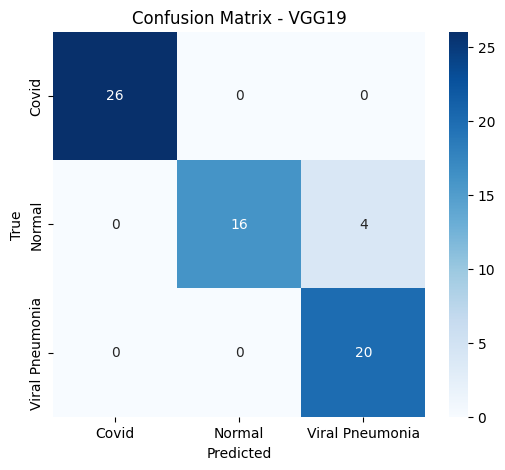

In [66]:
# Use the class_names you already defined earlier:
# class_names = ds_train_full.class_names

# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = vgg19_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG19')
plt.show()

In [67]:
# Classification Report
print("Classification Report (VGG19):")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report (VGG19):
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.80      0.89        20
Viral Pneumonia       0.83      1.00      0.91        20

       accuracy                           0.94        66
      macro avg       0.94      0.93      0.93        66
   weighted avg       0.95      0.94      0.94        66



## ROC Curves and AUC (One-vs-Rest, Multi-class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


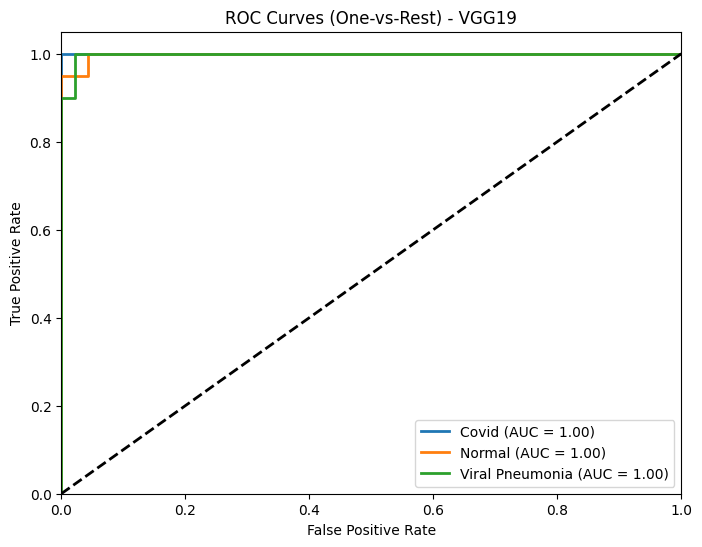

In [68]:
# ROC, AOC Curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get the number of classes (should match your dataset)
n_classes = len(class_names)

# Gather true (one-hot) and predicted probabilities
y_true_bin = []
y_pred_probs = []

for images, labels in ds_test:
    preds = vgg19_model.predict(images)
    y_pred_probs.append(preds)
    y_true_bin.append(labels.numpy())

y_true_bin = np.concatenate(y_true_bin, axis=0)        # shape: (num_samples, n_classes)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)    # shape: (num_samples, n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - VGG19')
plt.legend(loc="lower right")
plt.show()

# VGG16 Fine-Tuned

In [84]:
# 1. Load Pretrained VGG16 base
base_vgg16 = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_vgg16.trainable = False  # Freeze base model

In [85]:
# 2. Build VGG16 + Fine-Tuning Model (with extra layers)
model_vgg16_finetune = models.Sequential([
    base_vgg16,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')  # 3 classes
])

In [87]:
# 3. Compile the model
model_vgg16_finetune.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [88]:
# 4. Early stopping
early_stop_vgg16_finetune = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

In [89]:
# 5. Train the model
history_vgg16_finetune = model_vgg16_finetune.fit(
    ds_train,
    epochs=80,
    validation_data=ds_val,
    callbacks=[early_stop_vgg16_finetune],
    verbose=1
)

Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4292 - loss: 2.0706 - val_accuracy: 0.4375 - val_loss: 2.3216
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5662 - loss: 2.0882 - val_accuracy: 0.9062 - val_loss: 0.3118
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7306 - loss: 1.0968 - val_accuracy: 0.8750 - val_loss: 0.2332
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8037 - loss: 0.6386 - val_accuracy: 0.9688 - val_loss: 0.0526
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8356 - loss: 0.4931 - val_accuracy: 0.9062 - val_loss: 0.1148
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8311 - loss: 0.3998 - val_accuracy: 0.9688 - val_loss: 0.0483
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9224 - loss: 0.2132 - val_accuracy: 0.9688 - val_loss: 0.0935
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.9224 - loss: 0.2175 - val_accuracy: 1.0000 - val_loss: 0.0339
Epoch 9/

In [90]:
# Evaluate model performance
vgg16ft_loss, vgg16ft_acc = model_vgg16_finetune.evaluate(ds_test, verbose=1)
print(f"VGG16 Fine-tuned Test Loss: {vgg16ft_loss:.4f}")
print(f"VGG16 Fine-tuned Test Accuracy: {vgg16ft_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9697 - loss: 0.0336
VGG16 Fine-tuned Test Loss: 0.0336
VGG16 Fine-tuned Test Accuracy: 0.9697


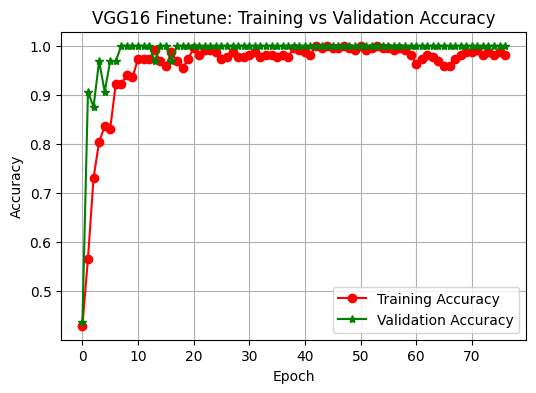

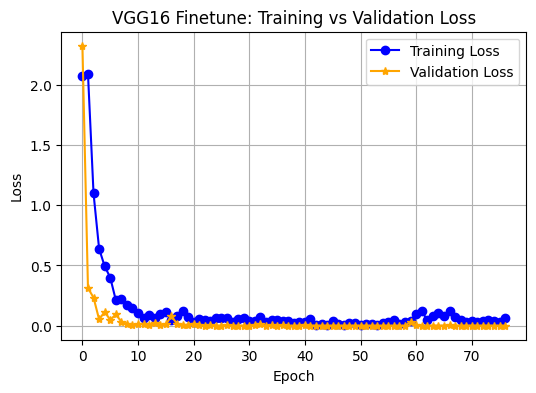

In [91]:
# Training vs Validation Accuracy and Loss

import matplotlib.pyplot as plt

# Training vs Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(history_vgg16_finetune.history['accuracy'], label='Training Accuracy', marker='o', color='red')
plt.plot(history_vgg16_finetune.history['val_accuracy'], label='Validation Accuracy', marker='*', color='green')
plt.title('VGG16 Finetune: Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Training vs Validation Loss
plt.figure(figsize=(6,4))
plt.plot(history_vgg16_finetune.history['loss'], label='Training Loss', marker='o', color='blue')
plt.plot(history_vgg16_finetune.history['val_loss'], label='Validation Loss', marker='*', color='orange')
plt.title('VGG16 Finetune: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


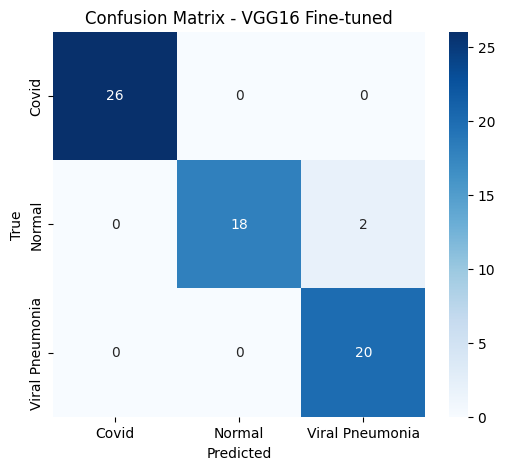

Classification Report (VGG16 Fine-tuned):
                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       1.00      0.90      0.95        20
Viral Pneumonia       0.91      1.00      0.95        20

       accuracy                           0.97        66
      macro avg       0.97      0.97      0.97        66
   weighted avg       0.97      0.97      0.97        66



In [92]:
# Confusion Matrix & Classification Report

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model_vgg16_finetune.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Use your predefined class_names
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VGG16 Fine-tuned')
plt.show()

print('Classification Report (VGG16 Fine-tuned):')
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


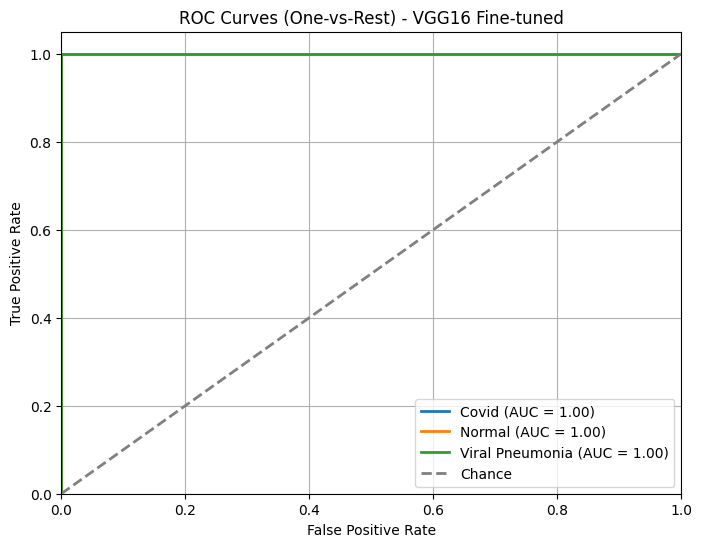

In [93]:
# ROC Curves & AUC

from sklearn.metrics import roc_curve, auc

n_classes = len(class_names)
y_true_bin = []
y_pred_probs = []

for images, labels in ds_test:
    preds = model_vgg16_finetune.predict(images)
    y_pred_probs.append(preds)
    y_true_bin.append(labels.numpy())

y_true_bin = np.concatenate(y_true_bin, axis=0)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - VGG16 Fine-tuned')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Data Augmentation with Pretrained model

In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2   # split training set into train/val
)


In [95]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Train & Validation Generators
ds_train_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",      # training subset
    seed=42
)

ds_val = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",    # validation subset
    seed=42
)

# Test Generator
ds_test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 201 images belonging to 3 classes.


Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [96]:
# Load Pretrained ResNet50
resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

In [97]:
resnet_base.trainable = False   


# Build Transfer Learning Model
resnet_model = Sequential([
    resnet_base,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation="softmax")   # 3 classes: Covid, Normal, Viral Pneumonia
])

# Compile Model
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,147,075 (92.11 MB)

 Trainable params: 558,595 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [98]:
# Define Callbacks

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

In [99]:
# Train the ResNet50 Model
history_resnet = resnet_model.fit(
    ds_train_aug,
    validation_data=ds_val,
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.4129 - loss: 1.5297 - val_accuracy: 0.4400 - val_loss: 1.3035
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4726 - loss: 1.3280 - val_accuracy: 0.4400 - val_loss: 1.2032
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5920 - loss: 1.1246 - val_accuracy: 0.4800 - val_loss: 1.1556
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5522 - loss: 1.1862 - val_accuracy: 0.2800 - val_loss: 1.1163
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5871 - loss: 0.9233 - val_accuracy: 0.2800 - val_loss: 1.1023
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5920 - loss: 1.0009 - val_accuracy: 0.2800 - val_loss: 1.1032
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6318 - loss: 1.0075 - val_accuracy: 0.2800 - val_loss: 1.1125
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6716 - loss: 0.9091 - val_accuracy: 0.2800 - val_loss: 1.1202


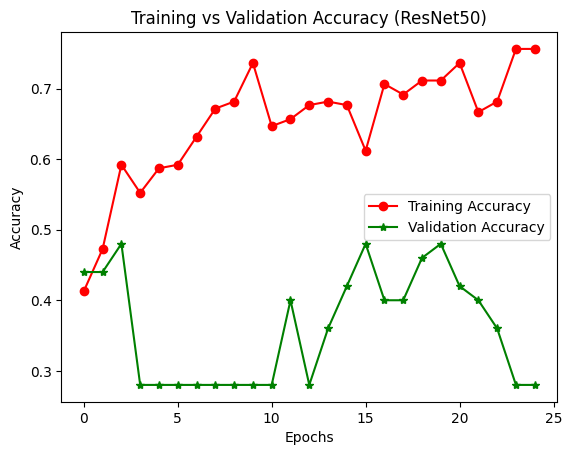

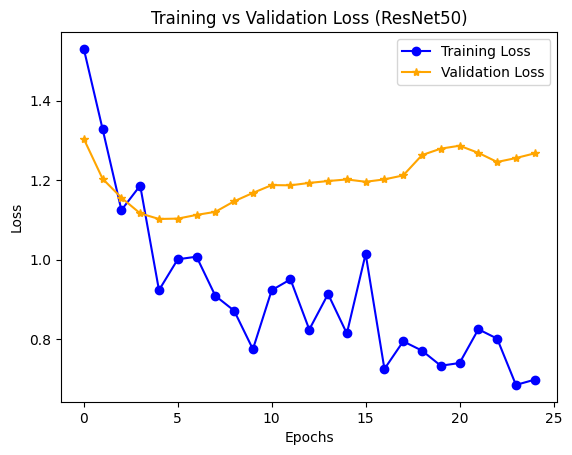

In [100]:
# Accuracy Plot
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy', marker='o', color='red')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', marker='*', color='green')
plt.title('Training vs Validation Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Loss Plot
plt.plot(history_resnet.history['loss'], label='Training Loss', marker='o', color='blue')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', marker='*', color='orange')
plt.title('Training vs Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate on Test Dataset
test_loss, test_acc = resnet_model.evaluate(ds_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 851ms/step - accuracy: 0.3030 - loss: 1.0925
Test Loss: 1.0925
Test Accuracy: 0.3030


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 764ms/step


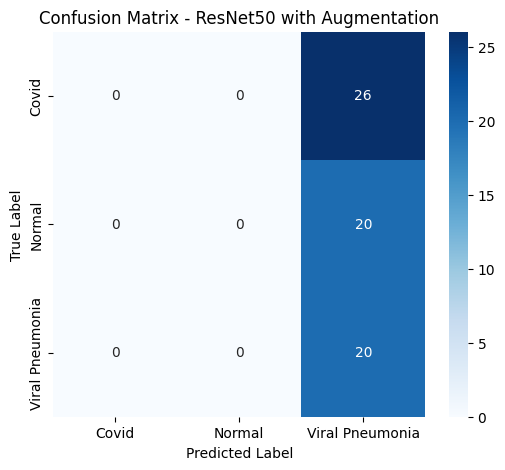

Classification Report - ResNet50 with Augmentation
                 precision    recall  f1-score   support

          Covid       0.00      0.00      0.00        26
         Normal       0.00      0.00      0.00        20
Viral Pneumonia       0.30      1.00      0.47        20

       accuracy                           0.30        66
      macro avg       0.10      0.33      0.16        66
   weighted avg       0.09      0.30      0.14        66



In [111]:
# Get model predictions and true labels
y_prob = resnet_model.predict(ds_test, verbose=1)      # Predicted probabilities
y_pred = np.argmax(y_prob, axis=1)                     # Predicted class indices
y_true = ds_test.classes                               # True class indices

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ResNet50 with Augmentation")
plt.show()

# Classification Report
print("Classification Report - ResNet50 with Augmentation")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


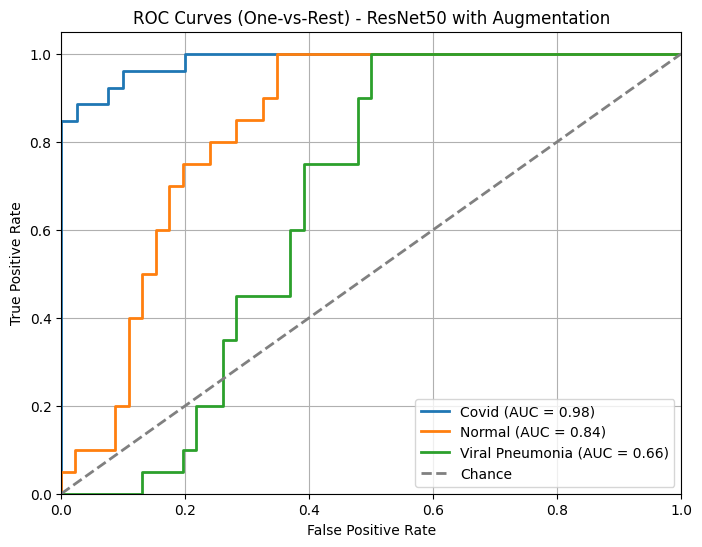

In [112]:
# ROC, AUC Curve

n_classes = len(class_names)
y_true_bin = []
y_pred_probs = []

# Loop through batches in ds_test
for i in range(len(ds_test)):
    images, labels = ds_test[i]
    preds = resnet_model.predict(images)
    y_pred_probs.append(preds)
    y_true_bin.append(labels)

# Concatenate results for full test set
y_true_bin = np.concatenate(y_true_bin, axis=0)
y_pred_probs = np.concatenate(y_pred_probs, axis=0)

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(8,6))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Chance', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest) - ResNet50 with Augmentation')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## Data Augmentation with VGG16

In [122]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # Train/Val split
)

test_datagen = ImageDataGenerator(rescale=1./255)

ds_train_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    seed=42
)

ds_val_aug = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    seed=42
)

ds_test_aug = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [123]:
vgg16_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

vgg16_base.trainable = False  # Freeze base layers initially


# Build Model with Fine-tuned Layers
model_vgg16_aug = models.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])


In [124]:
model_vgg16_aug.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_vgg16_aug.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,087,107 (107.14 MB)

 Trainable params: 13,372,419 (51.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [125]:
# Define Early Stopping and Train Model
early_stop_vgg16_aug = EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

# Train the Model
history_vgg16_aug = model_vgg16_aug.fit(
    ds_train_aug,
    validation_data=ds_val_aug,
    epochs=100,
    callbacks=[early_stop_vgg16_aug],
    verbose=1
)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.4229 - loss: 1.1662 - val_accuracy: 0.4400 - val_loss: 0.9735
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.4328 - loss: 1.1980 - val_accuracy: 0.7800 - val_loss: 0.8937
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5274 - loss: 1.0108 - val_accuracy: 0.5600 - val_loss: 0.8652
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5572 - loss: 0.9596 - val_accuracy: 0.7000 - val_loss: 0.7419
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6169 - loss: 0.8685 - val_accuracy: 0.5800 - val_loss: 0.7432
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.5572 - loss: 0.8523 - val_accuracy: 0.7200 - val_loss: 0.7235
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6617 - loss: 0.7121 - val_accuracy: 0.7400 - val_loss: 0.6697
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6915 - loss: 0.6691 - val_accuracy: 0.7200 - val_loss: 0.6305


In [127]:
# Validation Accuracy & Loss
val_loss, val_acc = model_vgg16_aug.evaluate(ds_val, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Test Accuracy & Loss
test_loss, test_acc = model_vgg16_aug.evaluate(ds_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9200 - loss: 0.2016
Validation Loss: 0.2016
Validation Accuracy: 0.9200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9394 - loss: 0.1548
Test Loss: 0.1548
Test Accuracy: 0.9394


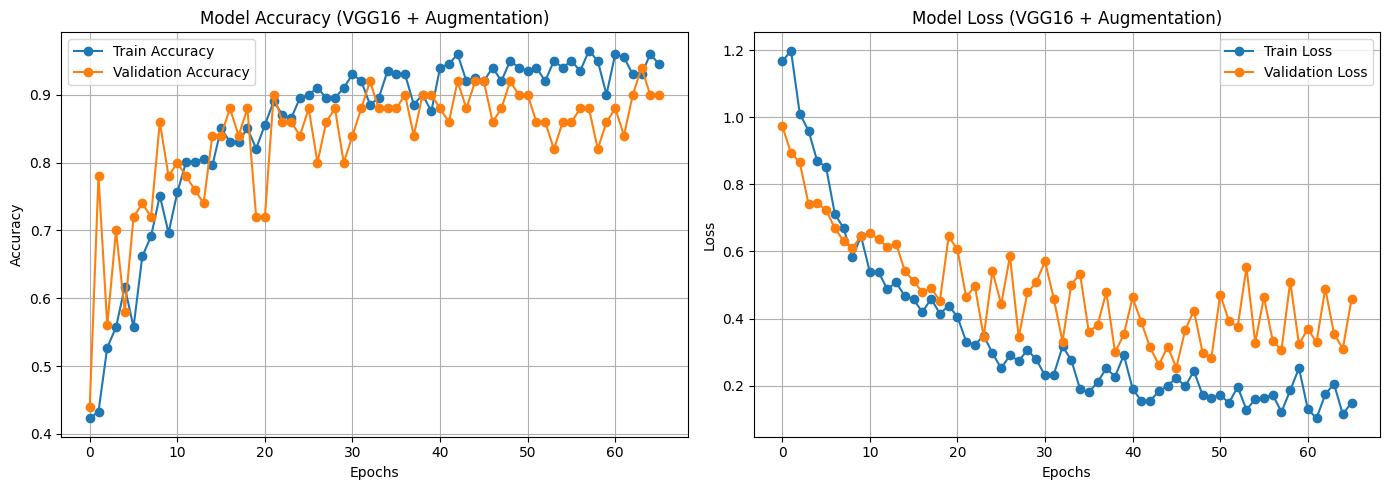

In [126]:
# Plot Training vs Validation Accuracy & Loss

# Accuracy & Loss Plots for VGG16 + Augmentation Model
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg16_aug.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_vgg16_aug.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy (VGG16 + Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg16_aug.history['loss'], label='Train Loss', marker='o')
plt.plot(history_vgg16_aug.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss (VGG16 + Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## Confusion Matrix and Classification Report

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


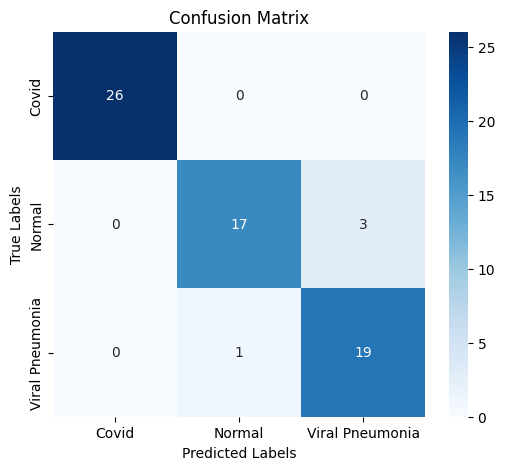


Classification Report:

                 precision    recall  f1-score   support

          Covid       1.00      1.00      1.00        26
         Normal       0.94      0.85      0.89        20
Viral Pneumonia       0.86      0.95      0.90        20

       accuracy                           0.94        66
      macro avg       0.94      0.93      0.93        66
   weighted avg       0.94      0.94      0.94        66



In [128]:
# Get Predictions on Test Set
y_pred_probs = model_vgg16_aug.predict(ds_test_aug)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = ds_test_aug.classes  # Ground truth labels

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

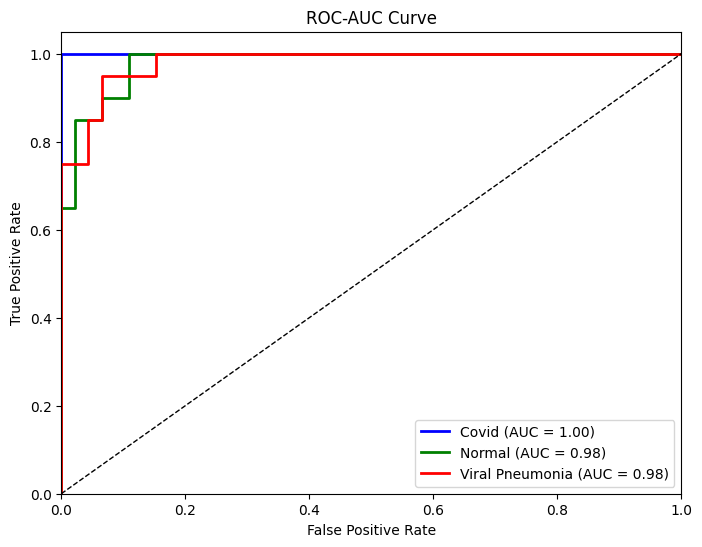

In [130]:
#ROC,AUC CURVE

from itertools import cycle

# Convert y_true to one-hot encoded
from tensorflow.keras.utils import to_categorical
y_true_onehot = to_categorical(y_true_classes, num_classes=len(class_names))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "green", "red"])  # Colors for classes

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.show()


# Model Tuning with KerasTuner

### Define the Model-Building Function

In [137]:
import keras_tuner as kt

def build_basic_cnn(hp):
    model = Sequential()
    model.add(Input(shape=(224, 224, 3)))

    # Conv Layer 1
    model.add(Conv2D(
        filters=hp.Choice('conv1_filters', values=[32, 64, 128]), 
        kernel_size=(3,3), 
        activation='relu',
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv Layer 2
    model.add(Conv2D(
        filters=hp.Choice('conv2_filters', values=[32, 64, 128]),
        kernel_size=(3,3), 
        activation='relu',
        padding='same'
    ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Dense Layer
    model.add(Dense(
        units=hp.Choice('dense_units', values=[64, 128, 256]),
        activation='relu'
    ))
    
    # Dropout Layer
    model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(3, activation='softmax'))

    # Optimizer with tunable learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [138]:
# Setting Up the Tuner
# I am using Random Search CV as its simpler

tuner = kt.RandomSearch(
    build_basic_cnn,
    objective='val_accuracy',
    max_trials=5,   # Number of different hyperparameter combinations to try
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner_dir',
    project_name='covid_basic_cnn'
)

In [139]:
# Running the Tuning

tuner.search(ds_train_aug, 
             validation_data=ds_val_aug,
             epochs=20,
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 5 Complete [00h 03m 15s]
val_accuracy: 0.6000000238418579

Best val_accuracy So Far: 0.6399999856948853
Total elapsed time: 00h 16m 35s


In [140]:
# Get the Best Hyperparameters

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
Conv1 Filters: {best_hps.get('conv1_filters')}
Conv2 Filters: {best_hps.get('conv2_filters')}
Dense Units: {best_hps.get('dense_units')}
Dropout: {best_hps.get('dropout')}
Learning Rate: {best_hps.get('learning_rate')}
""")



Best Hyperparameters:
Conv1 Filters: 128
Conv2 Filters: 32
Dense Units: 256
Dropout: 0.4
Learning Rate: 0.0001



In [141]:
# Training the Best Model

best_model = tuner.hypermodel.build(best_hps)

history_best = best_model.fit(
    ds_train_aug,
    validation_data=ds_val_aug,
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 60s 6s/step - accuracy: 0.5473 - loss: 2.7177 - val_accuracy: 0.3600 - val_loss: 1.1029
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.7711 - loss: 1.7211 - val_accuracy: 0.5400 - val_loss: 0.9425
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.7214 - loss: 1.8566 - val_accuracy: 0.6600 - val_loss: 0.8430
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.7662 - loss: 1.2454 - val_accuracy: 0.4600 - val_loss: 1.0219
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.7811 - loss: 1.1045 - val_accuracy: 0.4400 - val_loss: 1.9404
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.8060 - loss: 0.9320 - val_accuracy: 0.4400 - val_loss: 2.9600
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7711 - loss: 0.7403 - val_accuracy: 0.4400 - val_loss: 3.8949
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.7811 - loss: 0.6662 - val_accuracy: 0.4400 - val_loss: 4.8108
Epoch 9/

## Evaluate All Models

In [146]:
from sklearn.metrics import f1_score

# Helper function to calculate metrics
def evaluate_model(model, ds_train, ds_test, model_name):
    # Evaluate on train
    train_loss, train_acc = model.evaluate(ds_train, verbose=0)

    # Evaluate on test
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)

    # Get predictions for F1-score
    y_true = ds_test.classes
    y_pred_probs = model.predict(ds_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate weighted F1-score (for multi-class classification)
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Detect overfitting: big gap between train & test accuracy
    overfit_flag = "Yes" if (train_acc - test_acc) > 0.05 else "No"

    return {
        "Model": model_name,
        "Train Acc": round(train_acc, 4),
        "Test Acc": round(test_acc, 4),
        "F1 Score": round(f1, 4),
        "Overfitting (Y/N)": overfit_flag
    }


# Evaluate All Your Models
results = []

# Basic CNN
results.append(evaluate_model(basic_model, ds_train, ds_test, "CNN Basic"))

# VGG16 (Without Augmentation)
results.append(evaluate_model(model_transfer, ds_train, ds_test, "VGG16"))

# ResNet50(Without Augmentation)
results.append(evaluate_model(resnet_model, ds_train_aug, ds_test_aug, "ResNet50"))

# VGG19 (Without Augmentation)
results.append(evaluate_model(vgg19_model, ds_train, ds_test, "VGG19"))

# VGG16 (Fine Tune)
results.append(evaluate_model(model_vgg16_finetune, ds_train, ds_test, "VGG16"))

# ResNet50 + Data Augmentation
results.append(evaluate_model(resnet_model, ds_train_aug, ds_test, "ResNet50 + Augmentation"))

# VGG16 + Data Augmentation + Fine-Tuning
results.append(evaluate_model(model_vgg16_aug, ds_train_aug, ds_test_aug, "VGG16 + Aug + Fine-tune"))

# Best Tuned CNN from Keras Tuner
results.append(evaluate_model(best_model, ds_train_aug, ds_test_aug, "Best Tuned CNN"))

# Convert results into DataFrame
comparison_df = pd.DataFrame(results)

print("\n Model Comparison Table:\n")
print(comparison_df)



 Model Comparison Table:

                     Model  Train Acc  Test Acc  F1 Score Overfitting (Y/N)
0                CNN Basic     0.5251    0.5455    0.4449                No
1                    VGG16     1.0000    0.9545    0.9543                No
2                 ResNet50     0.2786    0.3030    0.1409                No
3                    VGG19     0.9954    0.9394    0.9388               Yes
4                    VGG16     1.0000    0.9697    0.9696                No
5  ResNet50 + Augmentation     0.2786    0.3030    0.1409                No
6  VGG16 + Aug + Fine-tune     0.9502    0.9394    0.9392                No
7           Best Tuned CNN     0.6468    0.6364    0.6499                No


In [148]:
# Helper function to calculate metrics
def evaluate_model(model, ds_train, ds_test, model_name):
    # Evaluate on train
    train_loss, train_acc = model.evaluate(ds_train, verbose=0)
    # Evaluate on test
    test_loss, test_acc = model.evaluate(ds_test, verbose=0)

    # Get predictions for F1-score
    # Robust: Try to get y_true from generator, else handle tf.data.Dataset (if used)
    if hasattr(ds_test, "classes"):
        y_true = ds_test.classes  # For ImageDataGenerator.flow_from_directory
    else:
        # For tf.data.Dataset, assuming (image_batch, label_batch) pairs, extract all
        y_true = []
        for _, labels in ds_test:
            if hasattr(labels, "numpy"):  # TF tensor
                labels = labels.numpy()
            if len(labels.shape) > 1 and labels.shape[1] > 1:  # one-hot
                labels = np.argmax(labels, axis=1)
            y_true.extend(labels)
        y_true = np.array(y_true)

    # Model predictions
    y_pred_probs = model.predict(ds_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate weighted F1-score (for multi-class classification)
    f1 = f1_score(y_true, y_pred, average="weighted")

    # Detect overfitting: big gap between train & test accuracy
    overfit_flag = "Yes" if (train_acc - test_acc) > 0.05 else "No"

    # Optionally include the gap for transparency (can comment/remove)
    #acc_gap = round(train_acc - test_acc, 4)

    return {
        "Model": model_name,
        "Train Acc": round(train_acc, 4),
        "Test Acc": round(test_acc, 4),
        "F1 Score": round(f1, 4),
        #"Acc Gap": acc_gap,
        "Overfitting (Y/N)": overfit_flag
    }

# Evaluate All Your Models
results = []

# CNN Basic
results.append(evaluate_model(basic_model, ds_train, ds_test, "CNN Basic"))

# VGG16 (Without Augmentation)
results.append(evaluate_model(model_transfer, ds_train, ds_test, "VGG16 Basic"))

# ResNet50 (Without Augmentation)
results.append(evaluate_model(resnet_model, ds_train_aug, ds_test_aug, "ResNet50 Basic"))

# VGG19 (Without Augmentation)
results.append(evaluate_model(vgg19_model, ds_train, ds_test, "VGG19 Basic"))

# VGG16 (Fine Tune)
results.append(evaluate_model(model_vgg16_finetune, ds_train, ds_test, "VGG16 Fine-tune"))

# ResNet50 + Data Augmentation
results.append(evaluate_model(resnet_model, ds_train_aug, ds_test, "ResNet50 + Aug"))

# VGG16 + Data Augmentation + Fine-Tuning
results.append(evaluate_model(model_vgg16_aug, ds_train_aug, ds_test_aug, "VGG16 + Aug + Fine-tune"))

# Best Tuned CNN from Keras Tuner
results.append(evaluate_model(best_model, ds_train_aug, ds_test_aug, "Best Tuned CNN"))

# Convert results into DataFrame
comparison_df = pd.DataFrame(results)

print("\nModel Comparison Table:\n")
print(comparison_df)


Model Comparison Table:

                     Model  Train Acc  Test Acc  F1 Score Overfitting (Y/N)
0                CNN Basic     0.5251    0.5455    0.4449                No
1              VGG16 Basic     1.0000    0.9545    0.9543                No
2           ResNet50 Basic     0.2786    0.3030    0.1409                No
3              VGG19 Basic     0.9954    0.9394    0.9388               Yes
4          VGG16 Fine-tune     1.0000    0.9697    0.9696                No
5           ResNet50 + Aug     0.2786    0.3030    0.1409                No
6  VGG16 + Aug + Fine-tune     0.9701    0.9394    0.9392                No
7           Best Tuned CNN     0.6070    0.6364    0.6499                No


# Saving the best model

In [150]:
model_vgg16_finetune.save("best_vgg16_finetune.h5")
print("Best model saved as best_vgg16_finetune.h5")

Best model saved as best_vgg16_finetune.h5


# Streamlit app

In [ ]:
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf  # Use tf.keras instead of tensorflow.keras

# CLASS NAMES FROM MY DATASET 
class_names = ["Covid", "Normal", "Viral Pneumonia"]

# LOADING THE BEST MODEL 
@st.cache_resource  # Won't reload every time
def load_my_model():
    model = tf.keras.models.load_model("best_vgg16_finetune.h5")  # tf.keras.models
    return model

model = load_my_model()

# IMAGE PREPROCESSING FUNCTION
def preprocess_image(img):
    # Convert to RGB (if uploaded as grayscale)
    if img.mode != "RGB":
        img = img.convert("RGB")
    # Resize to (224, 224) as per your model input
    img = img.resize((224, 224))
    # Convert to np.array and scale
    img = np.array(img).astype(np.float32) / 255.0  # Model expects scaled input
    # Expand dims for batch (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)
    return img

# STREAMLIT APP LAYOUT
st.title("Chest X-ray Classifier: Covid | Normal | Viral Pneumonia")
st.write("Upload a chest X-ray image (.jpg, .jpeg, .png)")

uploaded_file = st.file_uploader("Choose an X-ray image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded X-ray", use_column_width=True)

    # Preprocess
    img_preprocessed = preprocess_image(image)

    # Predict
    prediction = model.predict(img_preprocessed)
    pred_class = np.argmax(prediction, axis=1)[0]
    pred_conf = prediction[0][pred_class]

    st.write(f"**Prediction:** {class_names[pred_class]}")
    st.write(f"**Confidence:** {pred_conf:.2%}")

    # Show probability bar chart
    st.bar_chart(dict(zip(class_names, prediction[0])))

    # Probabilities in detail
    st.write("**Class Probabilities:**")
    for i, name in enumerate(class_names):
        st.write(f"{name}: {prediction[0][i]:.2%}")
